In [1]:
import os
import sys
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

sys.path.append("../")

from src.models import PhasePredictor
from src.datasets import PhaseDataset
from src.utils.constants import DATA_DIR, DEVICE, SEED

In [2]:
device = torch.device(DEVICE)

In [3]:
data_path = os.path.join(DATA_DIR, "labelled_dataset.npz")

data = np.load(data_path)

In [4]:
print(data.files)

['X', 'Y', 'X_labels', 'X_qual_num_classes', 'reaction_ids']


In [5]:
X = data["X"]
Y = data["Y"]
X_labels = data['X_labels']
qual_input_dims = data['X_qual_num_classes']

num_data_points = X.shape[0]

In [6]:
random_indices = torch.randperm(num_data_points)
num_train = int(num_data_points*0.8)

X = torch.tensor(X, device=device).float()
Y = torch.tensor(Y, device=device).float()

train_dataset = PhaseDataset(X[random_indices[0:num_train]],
                             Y[random_indices[0:num_train]])
test_dataset = PhaseDataset(X[random_indices[num_train:]],
                            Y[random_indices[num_train:]])


class_sample_count = np.array([len(torch.where(train_dataset.Y == t)[0])
                               for t in np.unique(train_dataset.Y)])


class_sample_count = torch.tensor([len(torch.where(train_dataset.Y == t)[0])
                                   for t in np.unique(train_dataset.Y)])
weight = 1. / class_sample_count
samples_weight = torch.tensor([weight[t.long()] for t in train_dataset.Y])
sampler = WeightedRandomSampler(samples_weight,
                                len(samples_weight))
train_dataloader = DataLoader(train_dataset, batch_size=16,
                              sampler=sampler)
                              # sampler=sampler)

test_dataloader = DataLoader(test_dataset, batch_size=16,
                             shuffle=False)

In [7]:
pp = PhasePredictor(input_dim=X.shape[1], 
                    qual_input_dims=qual_input_dims, 
                    latent_dimension=64)
pp_opt = Adam(pp.parameters(), lr=3e-4)
pp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pp_opt, patience=10, factor=0.5, verbose=True)

/Users/junhalee/Desktop/perovskite-phase-pred/venv39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
writer = SummaryWriter(log_dir="./test_wrs/")
for epoch in range(400):
    num_train_batches = len(train_dataloader)
    num_test_batches = len(test_dataloader)

    epoch_train_loss = 0
    epoch_test_loss = 0
    for (train_x, train_y) in train_dataloader:
        pred_y = pp(train_x).flatten()
        #Bce loss
        loss = torch.nn.BCELoss()(pred_y, train_y)
        epoch_train_loss += loss
        pp_opt.zero_grad()
        loss.backward()
        pp_opt.step()

        epoch_train_loss += loss.item()
    
    for (test_x, test_y) in test_dataloader:
        pred_y = pp(test_x).flatten()
        loss = torch.nn.BCELoss()(pred_y, test_y)
        epoch_test_loss += loss.item()
    epoch_train_loss /= num_train_batches
    epoch_test_loss /= num_test_batches

    writer.add_scalar("Loss/train", epoch_train_loss, epoch)
    writer.add_scalar("Loss/test", epoch_test_loss, epoch)
    pp_scheduler.step(epoch_test_loss)
    

In [9]:
all_outputs = []
all_classes = []
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        outputs = pp(inputs)
        all_outputs.append(outputs)
        all_classes.append(classes)

In [10]:
all_outputs = torch.round(torch.cat(all_outputs)).flatten()
all_classes = torch.round(torch.cat(all_classes)).flatten()

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

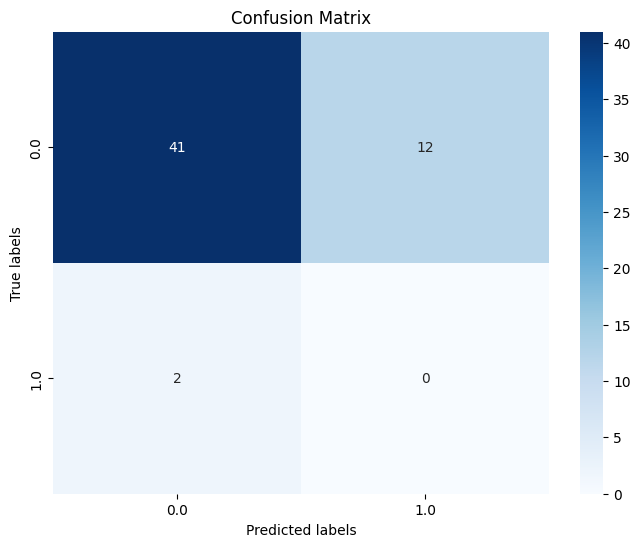

In [12]:
actual_labels = all_classes.tolist()
predicted_labels = all_outputs.tolist()

# Create confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(
    actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()